# Feature Engineering

One of the best ways to improve model performance is **feature engineering**. 

When feature engineering, we create additional columns using 
- domain knowledge
- combinations and interactions of features in the dataset
- additional lookups (e.g. the travel time for a patient from the clinic they are visiting rather than just learning from the postcode combinations)

Let's see if we can improve performance on the titanic dataset with a little feature engineering.


In [634]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, \
                            recall_score, roc_auc_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


We're going to import the raw data rather than the preprocessed data we've used in some cases as we want to make use of some of the additional features available in this dataset.

In [635]:
try:
    data = pd.read_csv("data/raw_data.csv")

except FileNotFoundError:

    # Download raw data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/train.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'raw_data.csv', index=False)

data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Binary features - Simple Conditions

First, let's make a feature that reflects whether the passenger is under 16. 

In [636]:
data['Under18'] = np.where(data['Age'] < 18 , 1, 0)
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1


## Binary Features - Using a combination of other columns

Next, let's make a column that reflects whether the passenger is travelling alone or with any family.

In [637]:
data['TravellingWithFamily'] = np.where(
    (data['SibSp'] + data['Parch']) >= 1, # Condition
    1, # Value if True
    0 # Value if False
    )

data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18,TravellingWithFamily
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,1


## Features from Complex String Patterns - Regular Expressions

Now let's extract groups of titles from the name column. 

We could extract each individual title, but if there are a lot, this could lead to a very high number of columns when we go to one-hot encode our data. What we want to mainly explore from titles is whether people were noble, general populace, or young. 

The easiest way to do this here is to use something called **Regular Expressions**.

Regular expressions allow us to match varying strings, like telephone numbers that may have different spacings or numbers of digits. We won't be using them to their full potential here! But they have the benefit of being usable with the `contains` method to allow us to pass a series of strings we would like to match with.

First, let's import the `re` library.

In [638]:
import re

Before turning this into a column, let's explore how we would match strings for a couple of categories of passengers.

Let's start with looking at upper-class titles.

Here, we're going to filter to rows where the 'name' column contains any one of

- Col.
- Capt.
- Don.
- Countess.
- Dr.
- Lady.
- Sir.
- Major.
- Rev.
- Jonkheer.
- Dona.

We want to ensure we look out for a `.` after these as in this dataset, a `.` is consistently used after a title. This is handy for us! 

However, in regex, a `.` has a special meaning - so we need to pass a `\` before it to tell the regular expression we're looking for an actual full stop. 

We then use the pipe `|` to denote `or`.

In [639]:
data[data['Name'].str.contains(r"Col\.|Capt\.|Don\.|Countess\.|Dr\.|Lady\.|Sir\.|Major\.|Rev\.|Jonkheer\.|Dona\.")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18,TravellingWithFamily
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,0,0
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S,0,0
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,0,0
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,0,1
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0000,NaN,S,0,1
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,0,0
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,0,0
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,0,0
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S,0,0
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,0,1


Let's repeat this to look at rows containing other groupings of titles.

What about 'regular' class people?

In [640]:
data[data['Name'].str.contains(r"Mrs\.|Mlle\.|Mr\.|Mons\.")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18,TravellingWithFamily
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S,0,0
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,0,0
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,0


Now let's look at instances relating to children.

In [641]:
data[data['Name'].str.contains(r"Master\.|Miss\.")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18,TravellingWithFamily
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,1
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,1,1
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,0,0
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,870,1,3,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,NaN,S,1,1
875,876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,7.2250,NaN,C,1,0
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0,0


Let's put in all of the ones we've come up with so far and check we haven't missed anyone.

We've used the `~` operator to filter our dataframe to instances where a match has NOT been found instead.

In [642]:
data[~data['Name'].str.contains(r"Master\.|Miss\.|Mrs\.|Mlle\.|Mr\.|Mons\.|Col\.|Capt\.|Don\.|Countess\.|Dr\.|Lady\.|Sir\.|Major\.|Rev\.|Jonkheer\.|Dona\.")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18,TravellingWithFamily
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3,B35,C,0,0
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0,NaN,S,0,0


It looks like we've missed `Mme.` and `Ms.` so we'll make sure to add those into the 'Regular' status for our final query.

### Creating the column

Now we've explored and built our query, we can turn this into our final column.

We're going to use `np.where` again - this does get a bit complex with longer queries!

It effectively is structured like a big if-else clause.

`np.where(condition, value_if_true, value_if_false)`

We nest these by passing additional `np.where` statements in the `value if false` position.

This may feel familiar if you've had to do a big if clause in Excel!

(note that this would be a lot easier in a newer version of pandas - they released a 'case_when' function in v2.2 - those of you used to SQL may be familiar with that sort of thing)

First, let's just run the statement and see the output.

I've added in some extra complexity to look at the 'age' column as well for the first two instances.

You may wish to indent your code differently for readability - the indentation won't have any impact on the functioning here.

In [643]:
np.where(
    (data['Name'].str.contains(r"Master\.|Miss\.")) & (data['Age'] <18), "Young",
    np.where((data['Name'].str.contains(r"Miss\.")) & (data['Age'] >=18), "Unmarried Woman",
    np.where(data['Name'].str.contains(r"Mrs\.|Mlle\.|Mr\.|Mons\."), "Regular",
    np.where(data['Name'].str.contains(r"Col\.|Capt\.|Don\.|Countess\.|Dr\.|Lady\.|Sir\.|Major\.|Rev\.|Jonkheer\.|Dona\."), "Upper Class",
    "Unknown"
    )))
    )

array(['Regular', 'Regular', 'Unmarried Woman', 'Regular', 'Regular',
       'Regular', 'Regular', 'Young', 'Regular', 'Regular', 'Young',
       'Unmarried Woman', 'Regular', 'Regular', 'Young', 'Regular',
       'Young', 'Regular', 'Regular', 'Regular', 'Regular', 'Regular',
       'Young', 'Regular', 'Young', 'Regular', 'Regular', 'Regular',
       'Unknown', 'Regular', 'Upper Class', 'Regular', 'Unknown',
       'Regular', 'Regular', 'Regular', 'Regular', 'Regular',
       'Unmarried Woman', 'Young', 'Regular', 'Regular', 'Regular',
       'Young', 'Unmarried Woman', 'Regular', 'Regular', 'Unknown',
       'Regular', 'Regular', 'Young', 'Regular', 'Regular', 'Regular',
       'Regular', 'Regular', 'Unmarried Woman', 'Regular', 'Young',
       'Young', 'Regular', 'Unmarried Woman', 'Regular', 'Young',
       'Regular', 'Unknown', 'Regular', 'Regular', 'Young', 'Regular',
       'Regular', 'Young', 'Regular', 'Regular', 'Regular', 'Regular',
       'Regular', 'Regular', 'Young', 'Unm

We can see it outputs a numpy array - effectively a big list - with the matched statement for each row.

Now let's assign that to a column in our dataframe and take a look at it in context.

In [644]:
data['Title'] = np.where(
    (data['Name'].str.contains(r"Master\.|Miss\.")) & (data['Age'] <18), "Young",
    np.where((data['Name'].str.contains(r"Miss\.")) & (data['Age'] >=18), "Unmarried Woman",
    np.where(data['Name'].str.contains(r"Mrs\.|Mlle\.|Mr\.|Mons\."), "Regular",
    np.where(data['Name'].str.contains(r"Col\.|Capt\.|Don\.|Countess\.|Dr\.|Lady\.|Sir\.|Major\.|Rev\.|Jonkheer\.|Dona\."), "Upper Class",
    "Unknown"
    ))))

# Select just the name, age and title columns
# Return a random sample of 15 rows
data[['Name', 'Age', 'Title']].sample(15)

,Name,Age,Title
691,"Karun, Miss. Manca",4.0,Young
194,"Brown, Mrs. James Joseph (Margaret Tobin)",44.0,Regular
719,"Johnson, Mr. Malkolm Joackim",33.0,Regular
805,"Johansson, Mr. Karl Johan",31.0,Regular
125,"Nicola-Yarred, Master. Elias",12.0,Young
441,"Hampe, Mr. Leon",20.0,Regular
225,"Berglund, Mr. Karl Ivar Sven",22.0,Regular
354,"Yousif, Mr. Wazli",NaN,Regular
260,"Smith, Mr. Thomas",NaN,Regular
409,"Lefebre, Miss. Ida",NaN,Unknown


Finally, let's see how many people fall into each category.

In [645]:
data['Title'].value_counts()

Regular            644
Unmarried Woman     95
Young               87
Unknown             42
Upper Class         23
Name: Title, dtype: int64

## Feature from Simple String Patterns - Getting the Deck from the Cabin Number

Let's also work out which deck they were staying on based on the cabin number. 

Let's first look at a single cabin number from our dataframe.

In [646]:
data['Cabin'][1]

'C85'

On further inspection, it turns out that the first letter of the cabin string is **always** the deck number. 

We can just pull back the `.str` attribute in each case and pull out the 1st letter (in position 0 - remember Python counts from 0).

In [647]:
data['Deck'] = data['Cabin'].str[0]
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18,TravellingWithFamily,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,Regular,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,Regular,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,Unmarried Woman,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,Regular,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,Regular,NaN
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0,Regular,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,0,Regular,E
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,1,Young,NaN
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,1,Regular,NaN
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,1,Regular,NaN


Let's see how many people were on each deck, and how many didn't have a cabin number.

In [648]:
data['Deck'].value_counts(dropna=False)

NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: Deck, dtype: int64

### Numeric Columns - Adding Values - Family Size

Let's calculate the family size by adding two numeric columns together.

In [649]:
data['FamilySize'] = data['SibSp'] + data['Parch']

data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18,TravellingWithFamily,Title,Deck,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,Regular,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,Regular,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,Unmarried Woman,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,Regular,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,Regular,NaN,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0,Regular,NaN,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,0,Regular,E,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,1,Young,NaN,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,1,Regular,NaN,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,1,Regular,NaN,1


## Joining to Counts - Shared Tickets and the Impact on Fare

Apparently tickets were shared between families. Let's explore this.

By using the 'value_counts' method twice in a row 
- we first get a count of how many times each ticket number appeared, 
- and next we get a count of how many times a ticket was shared between 1 person, how many times a ticket was shared between 2 people, and so on. 

In [650]:
data['Ticket'].value_counts().value_counts()

1    547
2     94
3     21
4     11
7      3
6      3
5      2
Name: Ticket, dtype: int64

It looks like this might be interesting and might have some impact on our fare value as well - so let's create a column for fare per person.

First, though, we'll need to add a column for the counts of how many times a ticket does appear in the dataset.

We start by creating a dataframe from the counts.

In [651]:
ticket_counts_df = (pd.DataFrame(data['Ticket'].value_counts())
                    .reset_index()
                    .rename(columns={"Ticket": "NumPeopleTicketShared"})
                    )


ticket_counts_df

,index,NumPeopleTicketShared
0,347082,7
1,CA. 2343,7
2,1601,7
3,3101295,6
4,CA 2144,6
...,...,...
676,9234,1
677,19988,1
678,2693,1
679,PC 17612,1


Now we can join this back to our main dataframe. 

In [652]:
data = pd.merge(
    left=data, # Original Dataframe
    right=ticket_counts_df, # Count Dataframe
    left_on="Ticket", # Common column from original dataframe
    right_on="index", # Common column from count dataframe
    how="left" # Keep all rows from the original dataframe
).drop(columns='index') # Get rid of the extra column

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18,TravellingWithFamily,Title,Deck,FamilySize,NumPeopleTicketShared
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,Regular,NaN,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,Regular,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,Unmarried Woman,NaN,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,Regular,C,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,Regular,NaN,0,1


Now we can create a 'fare per person' column by dividing the fare by the number of people it's shared between. 

In [653]:
data['FarePerPerson'] = data['Fare'] / data['NumPeopleTicketShared']
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Under18,TravellingWithFamily,Title,Deck,FamilySize,NumPeopleTicketShared,FarePerPerson
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,Regular,NaN,1,1,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,Regular,C,1,1,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,Unmarried Woman,NaN,0,1,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,Regular,C,1,2,26.5500
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,Regular,NaN,0,1,8.0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,0,Upper Class,NaN,0,1,13.0000
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0,0,Unmarried Woman,B,0,1,30.0000
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0,1,Unknown,NaN,3,2,11.7250
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,0,Regular,C,0,1,30.0000


## Indicating Missing Values

We will be one-hot encoding the 'embarked' column. It can be helpful to provide an extra column to indcate when the relevant column contains a missing value.

In [654]:
data['Embarked_Missing'] = data['Embarked'].isna().astype('int')
data['Embarked_Missing'].value_counts()

0    889
1      2
Name: Embarked_Missing, dtype: int64

In a later step, we are going to *impute* values where existing values are missing.

It can help to have features indicating that a value was missing and replaced.

In [655]:
data['Age_Imputed'] = data['Age'].isna().astype('int')
data['Age_Imputed'].value_counts()

0    714
1    177
Name: Age_Imputed, dtype: int64

Let's remind ourselves what the dataframe looks like at this stage.

In [656]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Under18,TravellingWithFamily,Title,Deck,FamilySize,NumPeopleTicketShared,FarePerPerson,Embarked_Missing,Age_Imputed
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,0,1,Regular,NaN,1,1,7.2500,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,0,1,Regular,C,1,1,71.2833,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,0,0,Unmarried Woman,NaN,0,1,7.9250,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,0,1,Regular,C,1,2,26.5500,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,0,0,Regular,NaN,0,1,8.0500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,S,0,0,Upper Class,NaN,0,1,13.0000,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,S,0,0,Unmarried Woman,B,0,1,30.0000,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,S,0,1,Unknown,NaN,3,2,11.7250,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,C,0,0,Regular,C,0,1,30.0000,0,0


# Comparing performance

Finally, we need to do the remaining data preparation steps to make this data usable by machine learning models. 

In [657]:
###############################
# Replace unclear data values #
###############################
embarked_lookup = {
    'S': 'Southampton',
    'C':  'Cherbourg',
    'Q': 'Queenstown'
}

data['Embarked'] = data['Embarked'].apply(lambda row_value: embarked_lookup.get(row_value))

#######################
# One hot encoding    #
#######################
one_hot_embarked = pd.get_dummies(data['Embarked'], prefix='Embarked').astype('int')
# Drop the column as it is now encoded
data = data.drop('Embarked', axis = 1)
# Join the encoded df
data = data.join(one_hot_embarked)

one_hot_title = pd.get_dummies(data['Title'], prefix='Title').astype('int')
# Drop the column as it is now encoded
data = data.drop('Title', axis = 1)
# Join the encoded df
data = data.join(one_hot_title)

one_hot_deck = pd.get_dummies(data['Deck'], prefix='Deck').astype('int')
# Drop the column as it is now encoded
data = data.drop('Deck', axis = 1)
# Join the encoded df
data = data.join(one_hot_deck)

#######################
# Dichotomous columns #
#######################
data['Sex'].replace('male', 1, inplace=True)
data['Sex'].replace('female', 0, inplace=True)
data = data.rename(columns={'Sex': 'IsMale'})

#####################################
# Tidying up remaining column names #
#####################################
data = data.drop(columns=['Name', 'Ticket', 'Cabin'])

data.head()

,PassengerId,Survived,Pclass,IsMale,Age,SibSp,Parch,Fare,Under18,TravellingWithFamily,...,Title_Upper Class,Title_Young,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,1,0,3,1,22.0,1,0,7.2500,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,38.0,1,0,71.2833,0,1,...,0,0,0,0,1,0,0,0,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,0,35.0,1,0,53.1000,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,0,3,1,35.0,0,0,8.0500,0,0,...,0,0,0,0,0,0,0,0,0,0


### Original Dataset Performance

In [658]:
data.drop('PassengerId', inplace=True, axis=1)

X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)


In [659]:
print(f"Training Dataset Samples: {len(X_train)}")
print(f"Validation Dataset Samples: {len(X_validate)}")


Training Dataset Samples: 712
Validation Dataset Samples: 179


In [660]:
def impute_missing_df(df, impute_type="median"):
    imputed_df = df.copy()
    imputed_df.values[:] = SimpleImputer(missing_values=np.nan, strategy=impute_type).fit_transform(df)
    return imputed_df

X_train = impute_missing_df(X_train, impute_type="median")
X_validate = impute_missing_df(X_validate, impute_type="median")

In [661]:
def fit_assess(name="XGBoost",
              X_train=X_train, X_validate=X_validate,
              y_train=y_train, y_validate=y_validate,
              model=XGBClassifier(random_state=42)
              ):

     model.fit(X_train, y_train)

     y_pred_train = model.predict(X_train)
     y_pred_val = model.predict(X_validate)

     tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

     return (pd.DataFrame({
            'Accuracy (training)': np.mean(y_pred_train == y_train),
            'Accuracy (validation)': np.mean(y_pred_val == y_validate),
            'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
            'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
            "AUC": roc_auc_score(y_validate, y_pred_val),
            "f1": f1_score(y_validate, y_pred_val, average='macro'),
            "FP": fp,
            "FN": fn
          }, index=[name]
).round(3), model)

In [662]:
X_train.columns

Index(['Pclass', 'IsMale', 'Age', 'SibSp', 'Parch', 'Fare', 'Under18',
       'TravellingWithFamily', 'FamilySize', 'NumPeopleTicketShared',
       'FarePerPerson', 'Embarked_Missing', 'Age_Imputed',
       'Embarked_Cherbourg', 'Embarked_Queenstown', 'Embarked_Southampton',
       'Title_Regular', 'Title_Unknown', 'Title_Unmarried Woman',
       'Title_Upper Class', 'Title_Young', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T'],
      dtype='object')

In [663]:
original_columns = [
       'Pclass', 'IsMale', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_Missing', 'Age_Imputed',
       'Embarked_Cherbourg', 'Embarked_Queenstown', 'Embarked_Southampton'
    ]

before_engineering = fit_assess(
    X_train=X_train[original_columns],
    X_validate=X_validate[original_columns],
    name="Without Feature Engineering"
)

results_df = before_engineering[0]
results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Without Feature Engineering,0.969,0.804,0.799,0.795,0.795,0.797,16,19


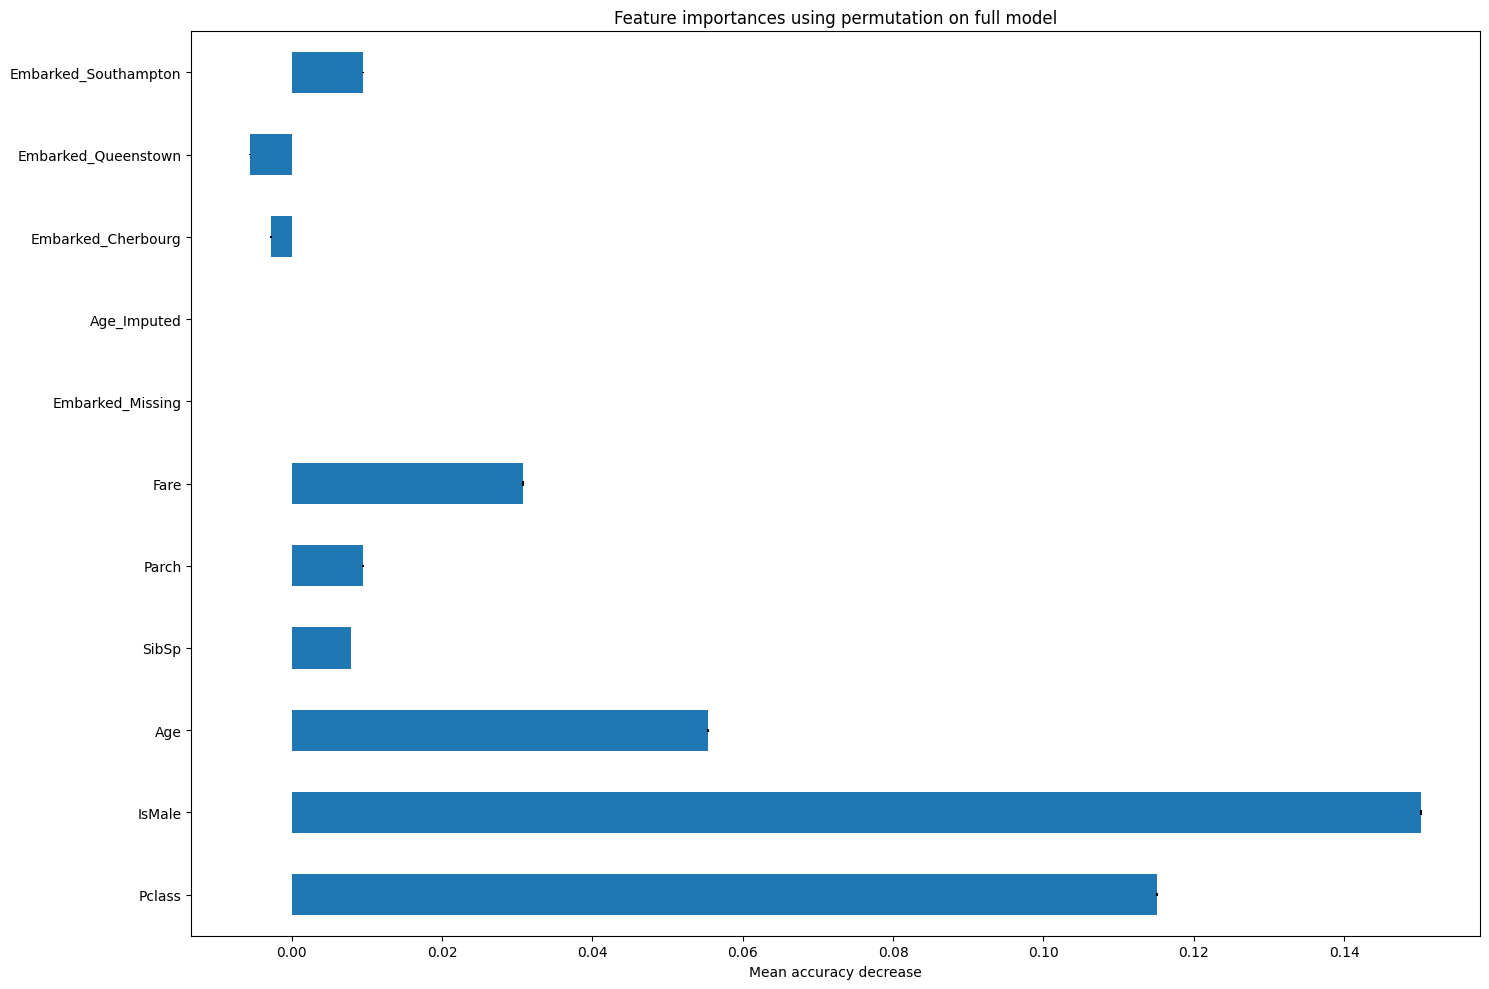

In [664]:
result_pfi = permutation_importance(
    before_engineering[1], X_validate[original_columns], y_validate,
    n_repeats=10, random_state=42, n_jobs=2
)

feature_importances_pfi = pd.Series(result_pfi.importances_mean, index=X_train[original_columns].columns.tolist())

fig, ax = plt.subplots(figsize=(15,10))
feature_importances_pfi.plot.barh(yerr=result_pfi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_xlabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [665]:
selected_columns = ['Pclass', 'IsMale', 'Age', 'SibSp', 'Parch', 'Fare']

before_engineering_2 = fit_assess(
    X_train=X_train[selected_columns],
    X_validate=X_validate[selected_columns],
    name="Before Feature Engineering - subset of columns"
)

results_df = pd.concat(
    [results_df,
     before_engineering_2[0]
     ]
)

results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Without Feature Engineering,0.969,0.804,0.799,0.795,0.795,0.797,16,19
Before Feature Engineering - subset of columns,0.963,0.810,0.806,0.800,0.800,0.803,15,19


## Performance with engineered features 

In [666]:
after_engineering = fit_assess(
    X_train=X_train,
    X_validate=X_validate,
    name="After Feature Engineering"
)

results_df = pd.concat([
    results_df,
    after_engineering[0]
])

results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Without Feature Engineering,0.969,0.804,0.799,0.795,0.795,0.797,16,19
Before Feature Engineering - subset of columns,0.963,0.810,0.806,0.800,0.800,0.803,15,19
After Feature Engineering,0.975,0.782,0.776,0.774,0.774,0.775,19,20


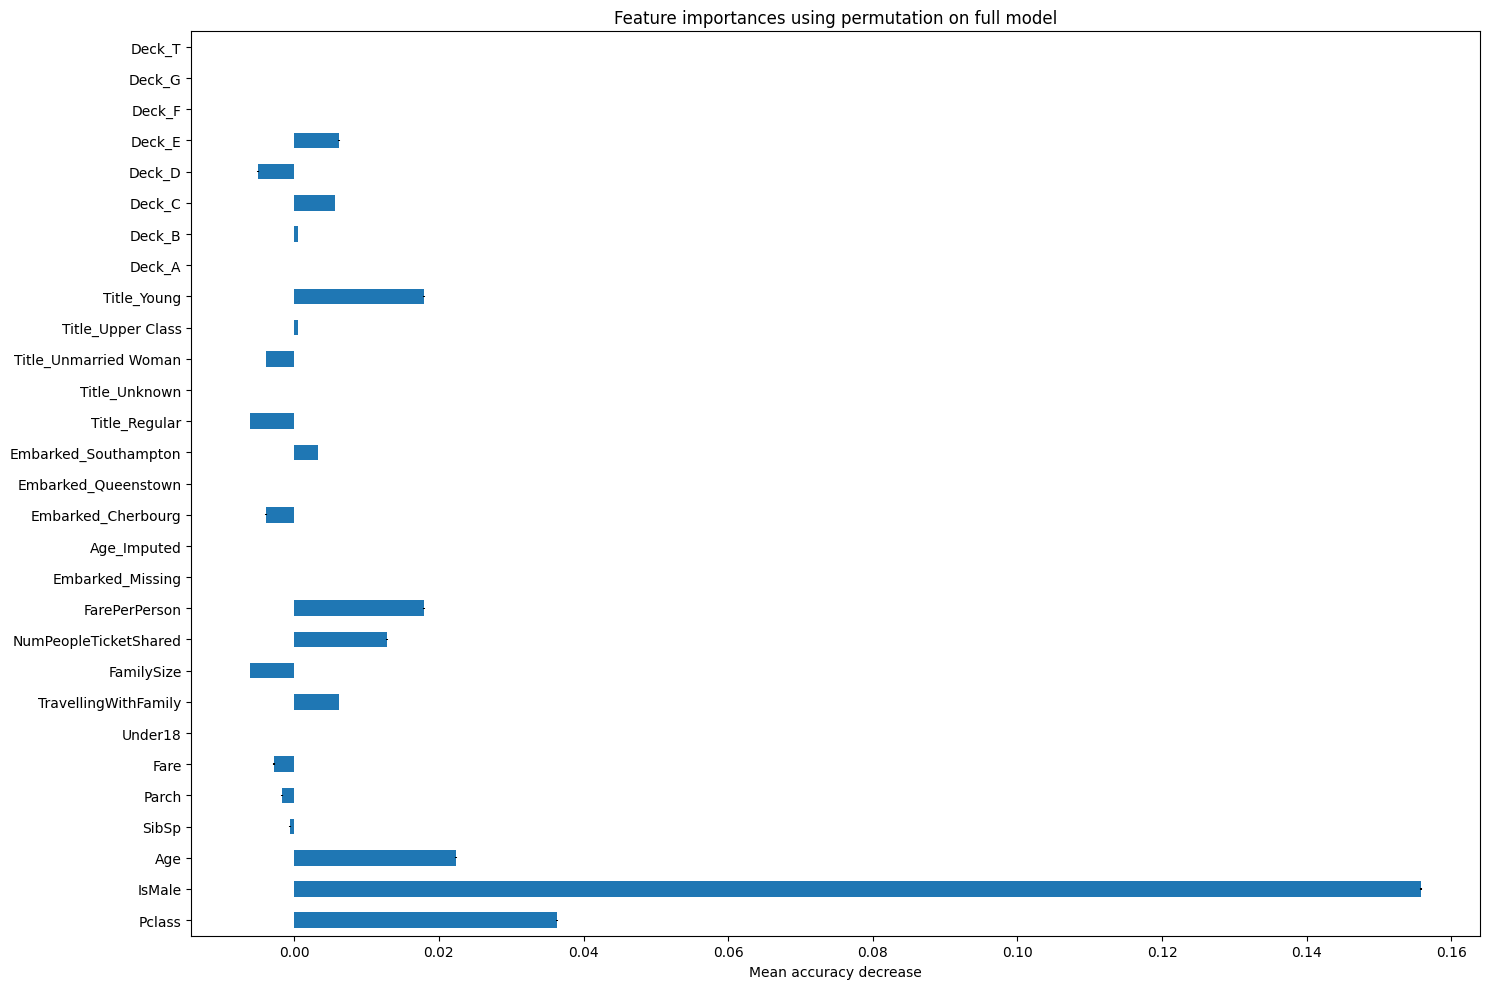

In [667]:
result_pfi = permutation_importance(
    after_engineering[1], X_validate, y_validate,
    n_repeats=10, random_state=42, n_jobs=2
)

feature_importances_pfi = pd.Series(result_pfi.importances_mean, index=X_train.columns.tolist())

fig, ax = plt.subplots(figsize=(15,10))
feature_importances_pfi.plot.barh(yerr=result_pfi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_xlabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Let's rerun with just some of the features that are the most impactful. 

In [668]:
selected_columns = ['Pclass', 'IsMale', 'Age', 'TravellingWithFamily', 'NumPeopleTicketShared', 'FarePerPerson']

after_engineering_2 = fit_assess(
    X_train=X_train[selected_columns],
    X_validate=X_validate[selected_columns],
    name="After Feature Engineering - subset of columns"
)

results_df = pd.concat(
    [results_df,
     after_engineering_2[0]
     ]
)

results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Without Feature Engineering,0.969,0.804,0.799,0.795,0.795,0.797,16,19
Before Feature Engineering - subset of columns,0.963,0.810,0.806,0.800,0.800,0.803,15,19
After Feature Engineering,0.975,0.782,0.776,0.774,0.774,0.775,19,20
After Feature Engineering - subset of columns,0.969,0.821,0.816,0.816,0.816,0.816,16,16


While minor in this case - and potentially further influenced by the number of features we have chosen and the method by which we have selected them - feature engineering can have a positive impact on your models, and this notebook has hopefully given you an insight into different strategies for creating additional columns in pandas.